In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
stocks = [
    "AMZN",        # Amazon
    "AAPL",        # Apple
    "GOOGL",       # Alphabet (Class A)
    "005930.KS",   # Samsung Electronics
    "2317.TW",     # Foxconn (Taiwan)
    "MSFT",        # Microsoft
    "JD",          # JD.com
    "BABA",        # Alibaba
    "T",           # AT&T
    "META"         # Meta (Facebook)
]

results_dir = "./results"
datasets_dir = "./datasets"

print("🟢 Stock Prediction Accuracy Analysis")
print("=" * 50)

🟢 Stock Prediction Accuracy Analysis


In [2]:
def get_actual_price(symbol, target_date):
    """Get actual closing price for a stock on a specific date"""
    try:
        df = pd.read_csv(f"{datasets_dir}/{symbol}_daily_data.csv")
        df['Date'] = pd.to_datetime(df['Date'])
        target_date_dt = pd.to_datetime(target_date)
        
        # Find the exact date or the closest business day
        matching_row = df[df['Date'] == target_date_dt]
        if not matching_row.empty:
            return matching_row['Close'].iloc[0]
        
        # If exact date not found, find the closest date after the target
        future_dates = df[df['Date'] > target_date_dt]
        if not future_dates.empty:
            return future_dates.iloc[0]['Close']
        
        return None
    except Exception as e:
        print(f"Error getting actual price for {symbol} on {target_date}: {e}")
        return None

def calculate_metrics(predicted, actual):
    """Calculate various accuracy metrics"""
    if actual == 0:
        return None
        
    absolute_error = abs(predicted - actual)
    percentage_error = (absolute_error / actual) * 100
    relative_error = (predicted - actual) / actual * 100
    
    return {
        'absolute_error': absolute_error,
        'percentage_error': percentage_error,
        'relative_error': relative_error,
        'accuracy': 100 - percentage_error
    }

print("✅ Helper functions defined")

✅ Helper functions defined


In [3]:
# === Process All Predictions ===
accuracy_data = []

# Get all available prediction dates
prediction_dates = []
if os.path.exists(results_dir):
    for date_folder in sorted(os.listdir(results_dir)):
        if os.path.isdir(os.path.join(results_dir, date_folder)):
            try:
                # Validate date format
                datetime.strptime(date_folder, '%Y-%m-%d')
                prediction_dates.append(date_folder)
            except ValueError:
                continue

print(f"📅 Found {len(prediction_dates)} prediction dates: {prediction_dates}")

# Process each prediction date
for pred_date in prediction_dates:
    print(f"⏳ Processing predictions for {pred_date}...")
    
    # Calculate target date (predictions are for the next day)
    pred_date_dt = datetime.strptime(pred_date, '%Y-%m-%d')
    target_date = (pred_date_dt + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Process both LSTM models
    for model_type in ['lstm', 'lstm_senti']:
        prediction_file = f"{results_dir}/{pred_date}/{model_type}.csv"
        
        if not os.path.exists(prediction_file):
            print(f"  ⚠️ Prediction file not found: {prediction_file}")
            continue
            
        pred_df = pd.read_csv(prediction_file)
        
        for _, row in pred_df.iterrows():
            symbol = row['symbol']
            predicted_price = row['predicted_price']
            
            actual_price = get_actual_price(symbol, target_date)
            
            if actual_price is not None:
                metrics = calculate_metrics(predicted_price, actual_price)
                
                if metrics:
                    result = {
                        'prediction_date': pred_date,
                        'target_date': target_date,
                        'symbol': symbol,
                        'model_type': model_type,
                        'predicted_price': predicted_price,
                        'actual_price': actual_price,
                        **metrics
                    }
                    accuracy_data.append(result)

print(f"✅ Processed {len(accuracy_data)} predictions")

# Convert to DataFrame for analysis
df_accuracy = pd.DataFrame(accuracy_data)
print(f"📊 Accuracy data shape: {df_accuracy.shape}")
df_accuracy.head()

📅 Found 11 prediction dates: ['2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-19', '2025-07-20', '2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24']
⏳ Processing predictions for 2025-07-14...
⏳ Processing predictions for 2025-07-15...
⏳ Processing predictions for 2025-07-16...
⏳ Processing predictions for 2025-07-17...


⏳ Processing predictions for 2025-07-18...
⏳ Processing predictions for 2025-07-19...
⏳ Processing predictions for 2025-07-20...
⏳ Processing predictions for 2025-07-21...
⏳ Processing predictions for 2025-07-22...
⏳ Processing predictions for 2025-07-23...
⏳ Processing predictions for 2025-07-24...
✅ Processed 180 predictions
📊 Accuracy data shape: (180, 10)


,prediction_date,target_date,symbol,model_type,predicted_price,actual_price,absolute_error,percentage_error,relative_error,accuracy
0,2025-07-14,2025-07-15,AMZN,lstm,221.41,226.350006,4.940006,2.182463,-2.182463,97.817537
1,2025-07-14,2025-07-15,AAPL,lstm,210.81,209.110001,1.699999,0.812969,0.812969,99.187031
2,2025-07-14,2025-07-15,GOOGL,lstm,178.56,182.000000,3.440000,1.890110,-1.890110,98.109890
3,2025-07-14,2025-07-15,005930.KS,lstm,61946.26,63700.000000,1753.740000,2.753124,-2.753124,97.246876
4,2025-07-14,2025-07-15,2317.TW,lstm,161.57,163.000000,1.430000,0.877301,-0.877301,99.122699


In [4]:
# === Summary Statistics ===
if len(df_accuracy) > 0:
    print("\n" + "="*60)
    print("📈 OVERALL ACCURACY STATISTICS")
    print("="*60)
    
    overall_stats = {
        'Total Predictions': len(df_accuracy),
        'Mean Accuracy (%)': df_accuracy['accuracy'].mean(),
        'Median Accuracy (%)': df_accuracy['accuracy'].median(),
        'Std Accuracy (%)': df_accuracy['accuracy'].std(),
        'Mean Percentage Error (%)': df_accuracy['percentage_error'].mean(),
        'Best Accuracy (%)': df_accuracy['accuracy'].max(),
        'Worst Accuracy (%)': df_accuracy['accuracy'].min()
    }
    
    for metric, value in overall_stats.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: {value}")
    
    print("\n" + "="*60)
    print("🤖 ACCURACY BY MODEL TYPE")
    print("="*60)
    
    model_stats = df_accuracy.groupby('model_type').agg({
        'accuracy': ['mean', 'median', 'std', 'count'],
        'percentage_error': 'mean'
    }).round(2)
    
    print(model_stats)
    
    print("\n" + "="*60)
    print("📊 ACCURACY BY STOCK SYMBOL")
    print("="*60)
    
    symbol_stats = df_accuracy.groupby('symbol').agg({
        'accuracy': ['mean', 'median', 'std', 'count'],
        'percentage_error': 'mean'
    }).round(2)
    
    print(symbol_stats)
else:
    print("❌ No accuracy data available for analysis")


📈 OVERALL ACCURACY STATISTICS
Total Predictions: 180
Mean Accuracy (%): 98.19
Median Accuracy (%): 98.50
Std Accuracy (%): 1.49
Mean Percentage Error (%): 1.81
Best Accuracy (%): 100.00
Worst Accuracy (%): 91.12

🤖 ACCURACY BY MODEL TYPE
           accuracy                    percentage_error
               mean median   std count             mean
model_type                                             
lstm          98.11  98.34  1.48    90             1.89
lstm_senti    98.28  98.64  1.50    90             1.72

📊 ACCURACY BY STOCK SYMBOL
          accuracy                    percentage_error
              mean median   std count             mean
symbol                                                
005930.KS    97.92  98.18  1.14    18             2.08
2317.TW      99.14  99.22  0.73    18             0.86
AAPL         98.88  98.77  0.63    18             1.12
AMZN         98.31  98.13  0.98    18             1.69
BABA         96.73  97.81  2.70    18             3.27
GOOGL        

In [5]:
from tabulate import tabulate

# Load the results from CSV
df = pd.read_csv('./accuracy_analysis_results.csv')

# Calculate mean accuracy for each stock
stock_accuracy = df.groupby('symbol')['accuracy'].mean().sort_values(ascending=False)

# Show mean accuracy for each stock and model type as a table
symbol_model = df.groupby(['symbol', 'model_type'])['accuracy'].mean().unstack()
symbol_model['overall'] = df.groupby('symbol')['accuracy'].mean()
print(tabulate(symbol_model.round(2), headers="keys", tablefmt="github"))


| symbol    |   lstm |   lstm_senti |   overall |
|-----------|--------|--------------|-----------|
| 005930.KS |  97.64 |        97.9  |     97.77 |
| 2317.TW   |  99.21 |        99.39 |     99.3  |
| AAPL      |  99.12 |        99.05 |     99.09 |
| AMZN      |  98.24 |        98.33 |     98.29 |
| BABA      |  96.34 |        96.29 |     96.32 |
| GOOGL     |  97.83 |        97.34 |     97.58 |
| JD        |  97.35 |        97.33 |     97.34 |
| META      |  98.59 |        98.67 |     98.63 |
| MSFT      |  97.25 |        99.22 |     98.23 |
| T         |  99.03 |        99.02 |     99.03 |


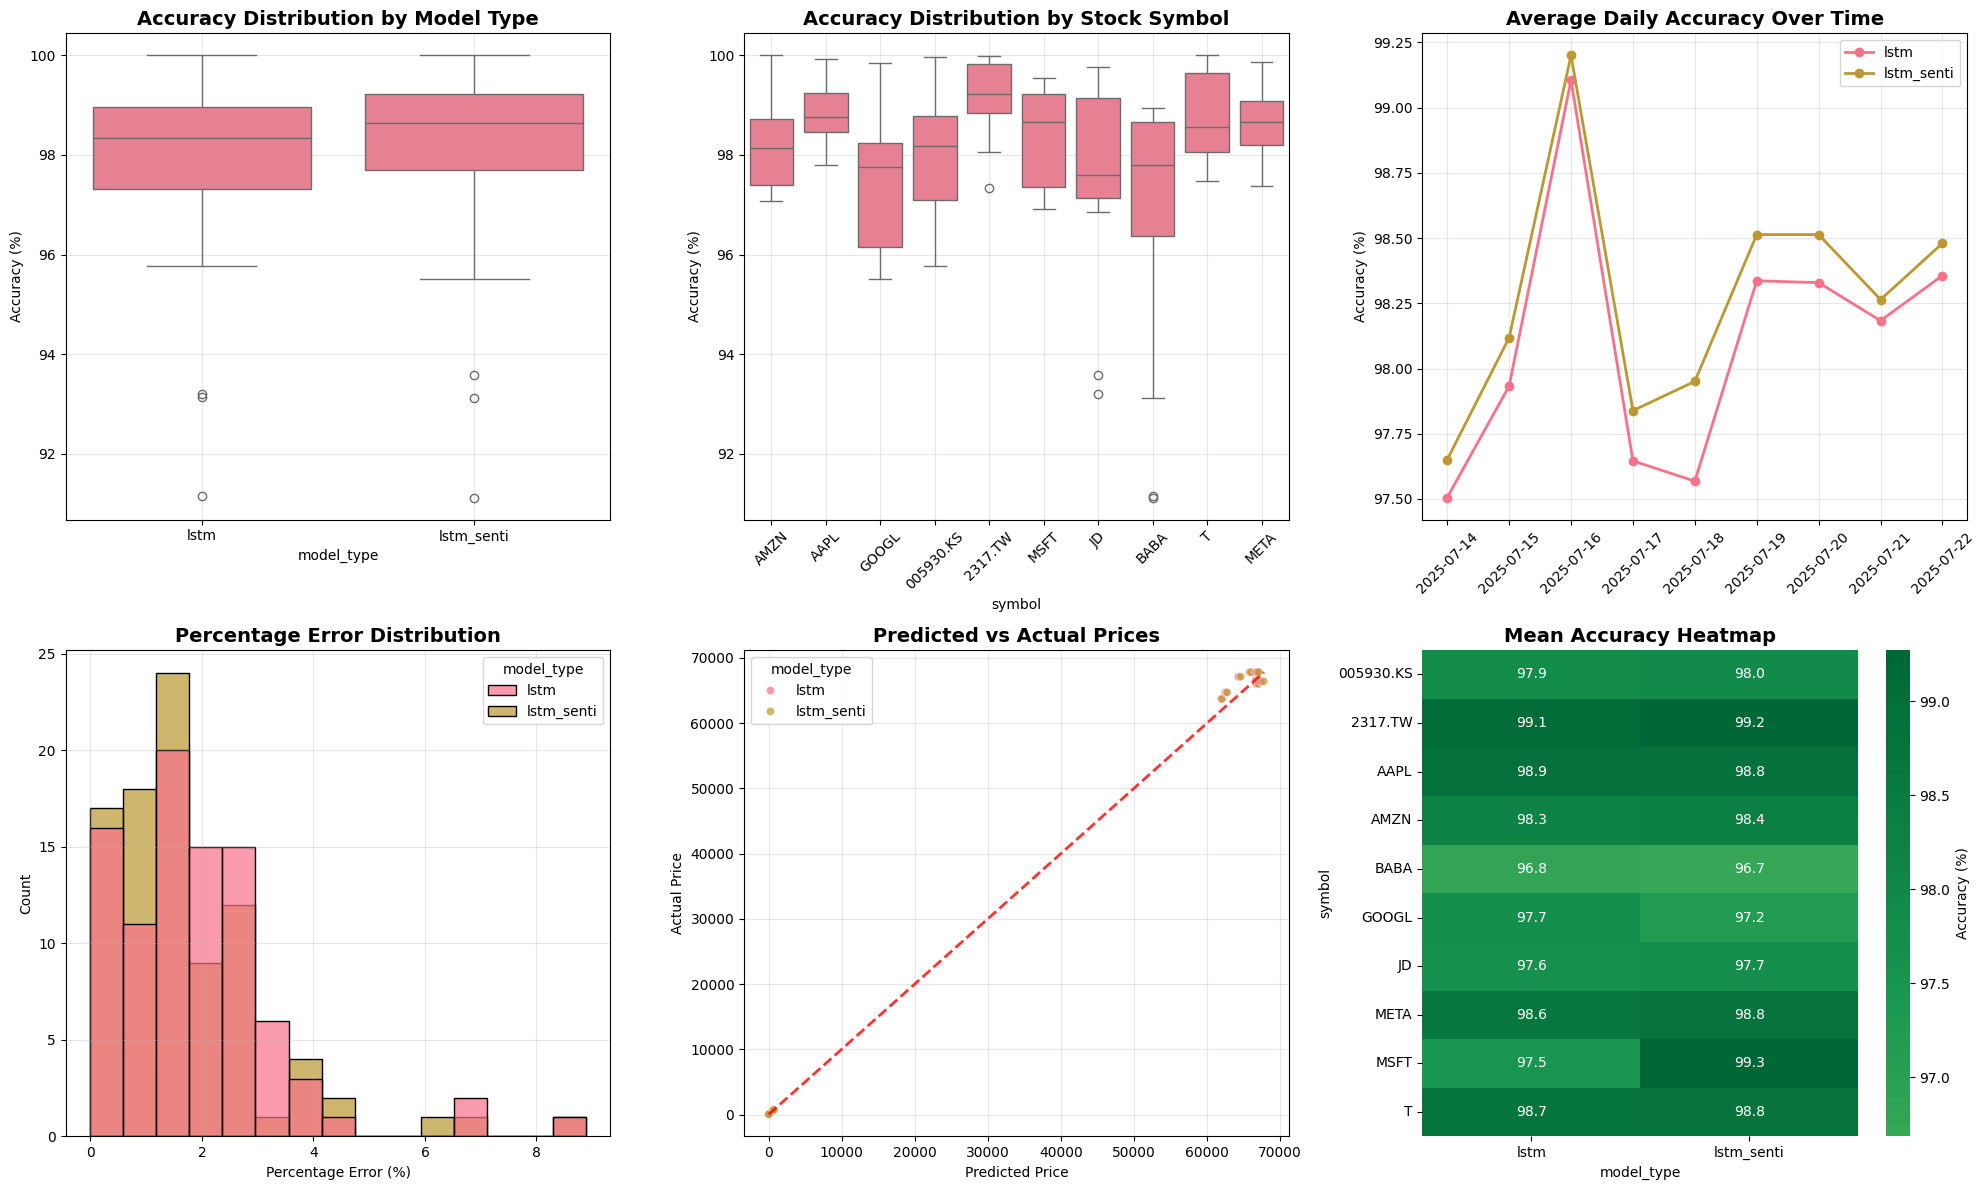

📈 Visualizations generated successfully!


In [6]:
# === Visualizations ===
if len(df_accuracy) > 0:
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Box plot of accuracy by model
    sns.boxplot(data=df_accuracy, x='model_type', y='accuracy', ax=axes[0,0])
    axes[0,0].set_title('Accuracy Distribution by Model Type', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot of accuracy by symbol
    sns.boxplot(data=df_accuracy, x='symbol', y='accuracy', ax=axes[0,1])
    axes[0,1].set_title('Accuracy Distribution by Stock Symbol', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Accuracy (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Time series of accuracy
    df_accuracy['prediction_date'] = pd.to_datetime(df_accuracy['prediction_date'])
    daily_accuracy = df_accuracy.groupby(['prediction_date', 'model_type'])['accuracy'].mean().reset_index()
    for model in daily_accuracy['model_type'].unique():
        model_data = daily_accuracy[daily_accuracy['model_type'] == model]
        axes[0,2].plot(model_data['prediction_date'], model_data['accuracy'], 
                      marker='o', linewidth=2, markersize=6, label=model)
    axes[0,2].set_title('Average Daily Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Accuracy (%)')
    axes[0,2].legend()
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Percentage error distribution
    sns.histplot(data=df_accuracy, x='percentage_error', hue='model_type', ax=axes[1,0], alpha=0.7)
    axes[1,0].set_title('Percentage Error Distribution', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Percentage Error (%)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Accuracy scatter plot
    sns.scatterplot(data=df_accuracy, x='predicted_price', y='actual_price', 
                   hue='model_type', alpha=0.7, ax=axes[1,1])
    # Add perfect prediction line
    min_val = min(df_accuracy['predicted_price'].min(), df_accuracy['actual_price'].min())
    max_val = max(df_accuracy['predicted_price'].max(), df_accuracy['actual_price'].max())
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    axes[1,1].set_title('Predicted vs Actual Prices', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Predicted Price')
    axes[1,1].set_ylabel('Actual Price')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Heatmap of mean accuracy by symbol and model
    symbol_model_accuracy = df_accuracy.groupby(['symbol', 'model_type'])['accuracy'].mean().reset_index()
    symbol_model_pivot = symbol_model_accuracy.pivot(index='symbol', columns='model_type', values='accuracy')
    
    sns.heatmap(symbol_model_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
               center=90, ax=axes[1,2], cbar_kws={'label': 'Accuracy (%)'})
    axes[1,2].set_title('Mean Accuracy Heatmap', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Visualizations generated successfully!")
else:
    print("❌ No data available for visualization")

In [7]:
# === Detailed Analysis ===
if len(df_accuracy) > 0:
    print("\n" + "="*60)
    print("🔍 DETAILED ANALYSIS")
    print("="*60)
    
    # Best and worst predictions
    best_prediction = df_accuracy.loc[df_accuracy['accuracy'].idxmax()]
    worst_prediction = df_accuracy.loc[df_accuracy['accuracy'].idxmin()]
    
    print(f"\n🏆 BEST PREDICTION:")
    print(f"   Stock: {best_prediction['symbol']}")
    print(f"   Model: {best_prediction['model_type']}")
    print(f"   Date: {best_prediction['target_date']}")
    print(f"   Predicted: ${best_prediction['predicted_price']:.2f}")
    print(f"   Actual: ${best_prediction['actual_price']:.2f}")
    print(f"   Accuracy: {best_prediction['accuracy']:.2f}%")
    
    print(f"\n❌ WORST PREDICTION:")
    print(f"   Stock: {worst_prediction['symbol']}")
    print(f"   Model: {worst_prediction['model_type']}")
    print(f"   Date: {worst_prediction['target_date']}")
    print(f"   Predicted: ${worst_prediction['predicted_price']:.2f}")
    print(f"   Actual: ${worst_prediction['actual_price']:.2f}")
    print(f"   Accuracy: {worst_prediction['accuracy']:.2f}%")
    
    # Model comparison
    print(f"\n⚖️ MODEL COMPARISON:")
    model_comparison = df_accuracy.groupby('model_type').agg({
        'accuracy': 'mean',
        'percentage_error': 'mean'
    }).round(2)
    
    lstm_accuracy = model_comparison.loc['lstm', 'accuracy']
    lstm_senti_accuracy = model_comparison.loc['lstm_senti', 'accuracy']
    
    if lstm_senti_accuracy > lstm_accuracy:
        diff = lstm_senti_accuracy - lstm_accuracy
        print(f"   🎯 LSTM with Sentiment performs better by {diff:.2f}%")
    else:
        diff = lstm_accuracy - lstm_senti_accuracy
        print(f"   🎯 Basic LSTM performs better by {diff:.2f}%")
    
    # Stock-specific insights
    print(f"\n📊 STOCK-SPECIFIC INSIGHTS:")
    stock_performance = df_accuracy.groupby('symbol')['accuracy'].mean().sort_values(ascending=False)
    
    print(f"   📈 Most Predictable: {stock_performance.index[0]} ({stock_performance.iloc[0]:.2f}%)")
    print(f"   📉 Least Predictable: {stock_performance.index[-1]} ({stock_performance.iloc[-1]:.2f}%)")
    
    # Save results
    print(f"\n💾 SAVING RESULTS:")
    df_accuracy.to_csv('accuracy_analysis_results.csv', index=False)
    print("   ✅ Detailed results saved to 'accuracy_analysis_results.csv'")
    
    # Summary for easy reference
    print(f"\n" + "="*60)
    print("📋 QUICK SUMMARY")
    print("="*60)
    print(f"🎯 Overall Mean Accuracy: {df_accuracy['accuracy'].mean():.2f}%")
    print(f"📊 Total Predictions Analyzed: {len(df_accuracy)}")
    print(f"📅 Date Range: {df_accuracy['target_date'].min()} to {df_accuracy['target_date'].max()}")
    print(f"📈 Best Model: {'LSTM + Sentiment' if lstm_senti_accuracy > lstm_accuracy else 'Basic LSTM'}")
    print(f"🏆 Most Accurate Stock: {stock_performance.index[0]}")
    print("="*60)
    
else:
    print("❌ No data available for detailed analysis")


🔍 DETAILED ANALYSIS

🏆 BEST PREDICTION:
   Stock: AMZN
   Model: lstm_senti
   Date: 2025-07-16
   Predicted: $223.19
   Actual: $223.19
   Accuracy: 100.00%

❌ WORST PREDICTION:
   Stock: BABA
   Model: lstm_senti
   Date: 2025-07-15
   Predicted: $106.58
   Actual: $116.97
   Accuracy: 91.12%

⚖️ MODEL COMPARISON:
   🎯 LSTM with Sentiment performs better by 0.17%

📊 STOCK-SPECIFIC INSIGHTS:
   📈 Most Predictable: 2317.TW (99.14%)
   📉 Least Predictable: BABA (96.73%)

💾 SAVING RESULTS:
   ✅ Detailed results saved to 'accuracy_analysis_results.csv'

📋 QUICK SUMMARY
🎯 Overall Mean Accuracy: 98.19%
📊 Total Predictions Analyzed: 180
📅 Date Range: 2025-07-15 to 2025-07-23
📈 Best Model: LSTM + Sentiment
🏆 Most Accurate Stock: 2317.TW
